In [1]:
import pandas as pd

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Load Dataset

dataset = pd.read_csv("CKD.csv")
dataset

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,2.000000,76.459948,c,3.0,0.0,normal,abnormal,notpresent,notpresent,148.112676,...,38.868902,8408.191126,4.705597,no,no,no,yes,yes,no,yes
1,3.000000,76.459948,c,2.0,0.0,normal,normal,notpresent,notpresent,148.112676,...,34.000000,12300.000000,4.705597,no,no,no,yes,poor,no,yes
2,4.000000,76.459948,a,1.0,0.0,normal,normal,notpresent,notpresent,99.000000,...,34.000000,8408.191126,4.705597,no,no,no,yes,poor,no,yes
3,5.000000,76.459948,d,1.0,0.0,normal,normal,notpresent,notpresent,148.112676,...,38.868902,8408.191126,4.705597,no,no,no,yes,poor,yes,yes
4,5.000000,50.000000,c,0.0,0.0,normal,normal,notpresent,notpresent,148.112676,...,36.000000,12400.000000,4.705597,no,no,no,yes,poor,no,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,51.492308,70.000000,a,0.0,0.0,normal,normal,notpresent,notpresent,219.000000,...,37.000000,9800.000000,4.400000,no,no,no,yes,poor,no,yes
395,51.492308,70.000000,c,0.0,2.0,normal,normal,notpresent,notpresent,220.000000,...,27.000000,8408.191126,4.705597,yes,yes,no,yes,poor,yes,yes
396,51.492308,70.000000,c,3.0,0.0,normal,normal,notpresent,notpresent,110.000000,...,26.000000,9200.000000,3.400000,yes,yes,no,poor,poor,no,yes
397,51.492308,90.000000,a,0.0,0.0,normal,normal,notpresent,notpresent,207.000000,...,38.868902,8408.191126,4.705597,yes,yes,no,yes,poor,yes,yes


In [3]:
#Basic Dataset Info

dataset.shape
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399 entries, 0 to 398
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             399 non-null    float64
 1   bp              399 non-null    float64
 2   sg              399 non-null    object 
 3   al              399 non-null    float64
 4   su              399 non-null    float64
 5   rbc             399 non-null    object 
 6   pc              399 non-null    object 
 7   pcc             399 non-null    object 
 8   ba              399 non-null    object 
 9   bgr             399 non-null    float64
 10  bu              399 non-null    float64
 11  sc              399 non-null    float64
 12  sod             399 non-null    float64
 13  pot             399 non-null    float64
 14  hrmo            399 non-null    float64
 15  pcv             399 non-null    float64
 16  wc              399 non-null    float64
 17  rc              399 non-null    flo

In [4]:
#Preprocessing Steps

#One-hot encoding
dataset = pd.get_dummies(dataset, columns = ['rbc', 'pc', 'pcc', 'ba', 'htn','dm','cad','appet','pe','ane','classification'], drop_first = True, dtype = int)
print(dataset.columns)

#Label encoding
label_encoder = LabelEncoder()
dataset['sg'] = label_encoder.fit_transform(dataset['sg'])
print(dataset['sg'].unique())

Index(['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hrmo',
       'pcv', 'wc', 'rc', 'rbc_normal', 'pc_normal', 'pcc_present',
       'ba_present', 'htn_yes', 'dm_yes', 'cad_yes', 'appet_yes', 'pe_yes',
       'ane_yes', 'classification_yes'],
      dtype='object')
[2 0 3 1 4]


In [5]:
# Split features/target

independent = dataset.drop(columns = ['classification_yes'], axis=1)
dependent = dataset[['classification_yes']]
print(dependent.value_counts())

#Train-test split
x_train, x_test, y_train, y_test = train_test_split(independent, dependent, test_size = 0.30, random_state = 0) 
x_train, x_test, y_train, y_test

#Scaling for LR & SVM
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

classification_yes
1                     249
0                     150
Name: count, dtype: int64


In [6]:
#Helper function for plotting Evaluation metrics

results = {}

def evaluate_model(model_name, model, X_test, y_test, y_prob):
    print(f"\n==================== {model_name} ====================")
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    clf_report = classification_report(y_test, y_pred)

    report = classification_report(y_test, y_pred, output_dict=True)
    results[model_name] = {
        "accuracy": acc,
        "precision": report["weighted avg"]["precision"],
        "recall": report["weighted avg"]["recall"],
        "f1": report["weighted avg"]["f1-score"]
    }

    print(f"Accuracy: {acc:.2f}")
    print("Confusion Matrix:\n", cm)
    print("Classification report:\n", clf_report)
    print(f"AUC Score: {auc:.2f}")

    #Create side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Confusion Matrix Heatmap
    # plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
    axes[0].set_title(f"{model_name} - Confusion Matrix")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")
    # plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    # plt.figure(figsize=(5,4))
    axes[1].plot(fpr, tpr, lw=2, label=f"AUC={auc:.2f}")
    axes[1].plot([0,1], [0,1], linestyle='--')
    # axes[1].set_xlim([0.0, 1.0])
    # axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel("False Positive Rate")
    axes[1].set_ylabel("True Positive Rate")
    axes[1].set_title(f"{model_name} - ROC Curve")
    axes[1].legend(loc="lower right")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


Best Logistic Regression Params: {'penalty': 'l2', 'solver': 'newton-cg'}

==================== Logistic Regression ====================
Accuracy: 0.98
Confusion Matrix:
 [[44  1]
 [ 1 74]]
Classification report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        45
           1       0.99      0.99      0.99        75

    accuracy                           0.98       120
   macro avg       0.98      0.98      0.98       120
weighted avg       0.98      0.98      0.98       120

AUC Score: 1.00


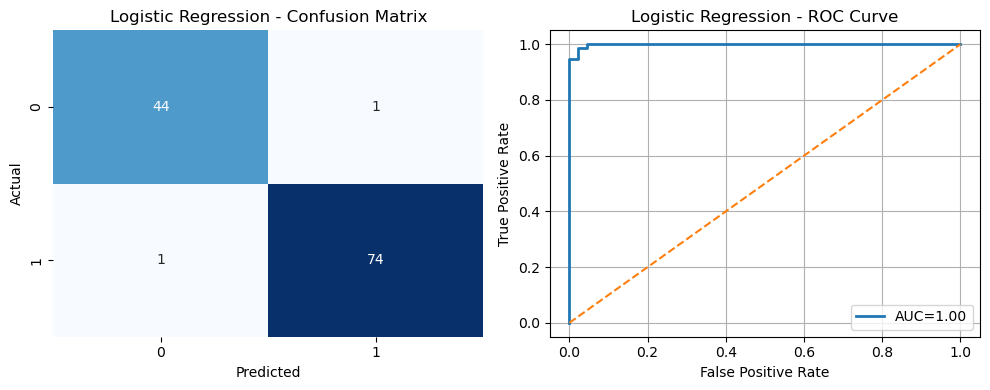

In [7]:
#Logistic Regression Model Creation

param_grid_log = {
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'saga'],
    'penalty':['l2']
}

grid_log = GridSearchCV(LogisticRegression(), param_grid_log, refit = True, cv=5, scoring='roc_auc', n_jobs=-1)

grid_log.fit(x_train, y_train)
best_log = grid_log.best_estimator_
print("\nBest Logistic Regression Params:", grid_log.best_params_)

y_prob = best_log.predict_proba(x_test)[:, 1]
evaluate_model("Logistic Regression", best_log, x_test, y_test, y_prob)


Best SVM Params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}

==================== SVM ====================
Accuracy: 0.97
Confusion Matrix:
 [[45  0]
 [ 4 71]]
Classification report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        45
           1       1.00      0.95      0.97        75

    accuracy                           0.97       120
   macro avg       0.96      0.97      0.97       120
weighted avg       0.97      0.97      0.97       120

AUC Score: 1.00


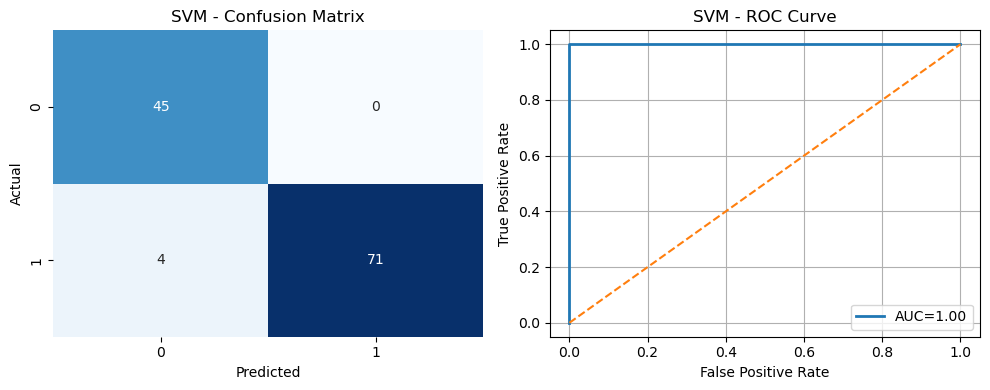

In [8]:
param_grid_svm = {
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'C': [0.1, 1, 10, 50, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001]
}

grid_svm = GridSearchCV(
    SVC(probability=True), #parameter for roc_auc
    param_grid_svm, 
    refit = True, 
    cv=5,               
    scoring='roc_auc',  # better metric for medical dataset
    n_jobs=1            # prevents overheating
)

grid_svm.fit(x_train_scaled, y_train)
best_svm = grid_svm.best_estimator_
print("\nBest SVM Params:", grid_svm.best_params_)

y_prob = best_svm.predict_proba(x_test_scaled)[:, 1]
evaluate_model("SVM", best_svm, x_test_scaled, y_test, y_prob)


Best Decision Tree Params: {'criterion': 'entropy', 'max_features': 'sqrt', 'splitter': 'random'}

==================== Decision Tree ====================
Accuracy: 0.96
Confusion Matrix:
 [[42  3]
 [ 2 73]]
Classification report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94        45
           1       0.96      0.97      0.97        75

    accuracy                           0.96       120
   macro avg       0.96      0.95      0.96       120
weighted avg       0.96      0.96      0.96       120

AUC Score: 0.95


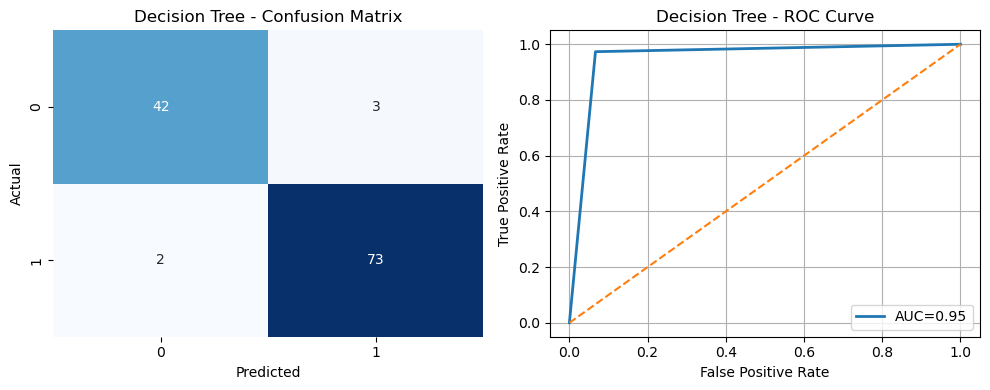

In [9]:
param_grid_dt = {
    'criterion':['gini','entropy'],
    'max_features': ['auto','sqrt','log2'],
    'splitter':['best','random']
}

grid_dt = GridSearchCV(
    DecisionTreeClassifier(), 
    param_grid_dt, 
    refit = True, 
    cv=5,              
    scoring='roc_auc',  
    n_jobs=-1            
)

grid_dt.fit(x_train, y_train)
best_dt = grid_dt.best_estimator_
print("\nBest Decision Tree Params:", grid_dt.best_params_)

y_prob = best_dt.predict_proba(x_test)[:, 1]
evaluate_model("Decision Tree", best_dt, x_test, y_test, y_prob)


Best Random Forest Params: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100}

==================== Random Forest ====================
Accuracy: 1.00
Confusion Matrix:
 [[45  0]
 [ 0 75]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       1.00      1.00      1.00        75

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120

AUC Score: 1.00


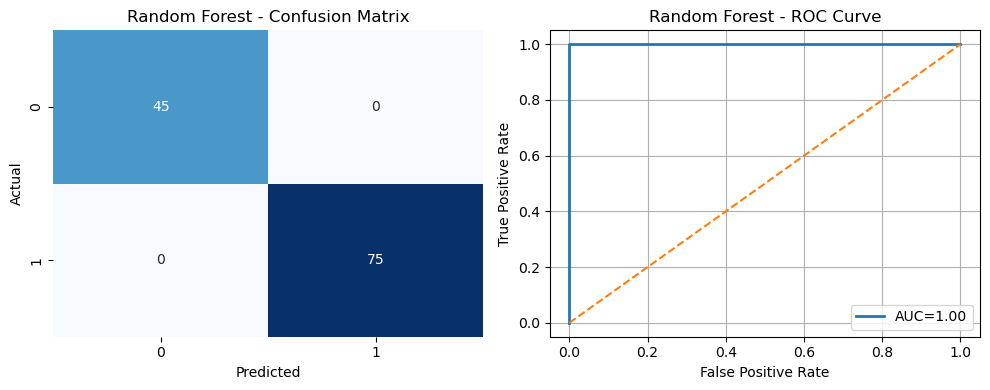

In [10]:
param_grid_rf = {
    'criterion':['gini','entropy'],
    'max_features': ['auto','sqrt','log2'],
    'n_estimators':[10,100]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(), 
    param_grid_rf, 
    refit = True, 
    cv=5,              
    scoring='roc_auc',  
    n_jobs=-1            
)

grid_rf.fit(x_train, y_train)
best_rf = grid_rf.best_estimator_
print("\nBest Random Forest Params:", grid_rf.best_params_)

y_prob = best_rf.predict_proba(x_test)[:, 1]
evaluate_model("Random Forest", best_rf, x_test, y_test, y_prob)


Best K-Nearest Params: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}

==================== K-Nearest Neighbors ====================
Accuracy: 0.78
Confusion Matrix:
 [[42  3]
 [24 51]]
Classification report:
               precision    recall  f1-score   support

           0       0.64      0.93      0.76        45
           1       0.94      0.68      0.79        75

    accuracy                           0.78       120
   macro avg       0.79      0.81      0.77       120
weighted avg       0.83      0.78      0.78       120

AUC Score: 0.85


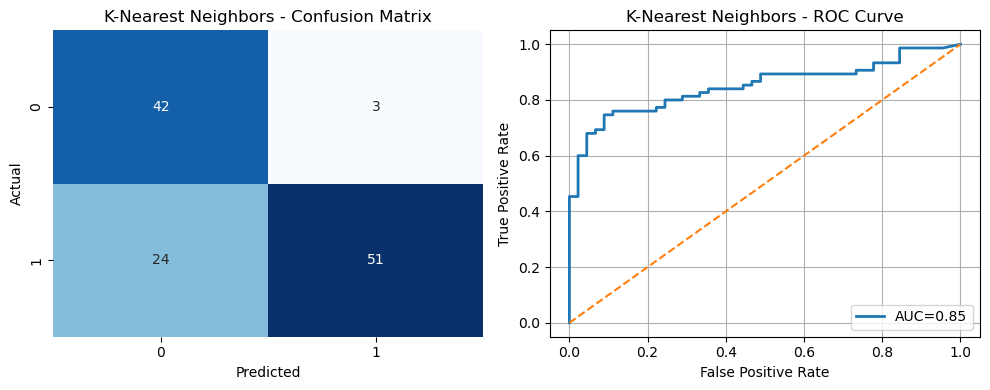

In [11]:
param_grid_knn = {
    'n_neighbors' : [5,7,9,11,13,15],
    'weights' : ['uniform','distance'],
    'metric' : ['minkowski','euclidean','manhattan']
}

grid_knn = GridSearchCV(
    KNeighborsClassifier(), 
    param_grid_knn, 
    refit = True, 
    cv=5,              
    scoring='roc_auc',  
    n_jobs=-1            
)

grid_knn.fit(x_train, y_train)
best_knn = grid_knn.best_estimator_
print("\nBest K-Nearest Params:", grid_knn.best_params_)

y_prob = best_knn.predict_proba(x_test)[:, 1]
evaluate_model("K-Nearest Neighbors", best_knn, x_test, y_test, y_prob)


==================== Gaussian Naive Bayes ====================
Accuracy: 0.95
Confusion Matrix:
 [[45  0]
 [ 6 69]]
Classification report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.94        45
           1       1.00      0.92      0.96        75

    accuracy                           0.95       120
   macro avg       0.94      0.96      0.95       120
weighted avg       0.96      0.95      0.95       120

AUC Score: 1.00


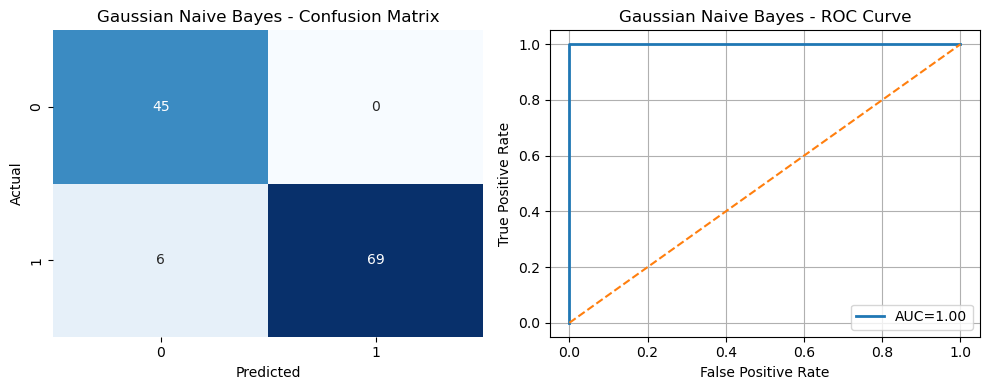

In [12]:
grid_gnb = GaussianNB()
grid_gnb.fit(x_train, y_train)
y_prob = grid_gnb.predict_proba(x_test)[:, 1]
evaluate_model("Gaussian Naive Bayes", grid_gnb, x_test, y_test, y_prob)

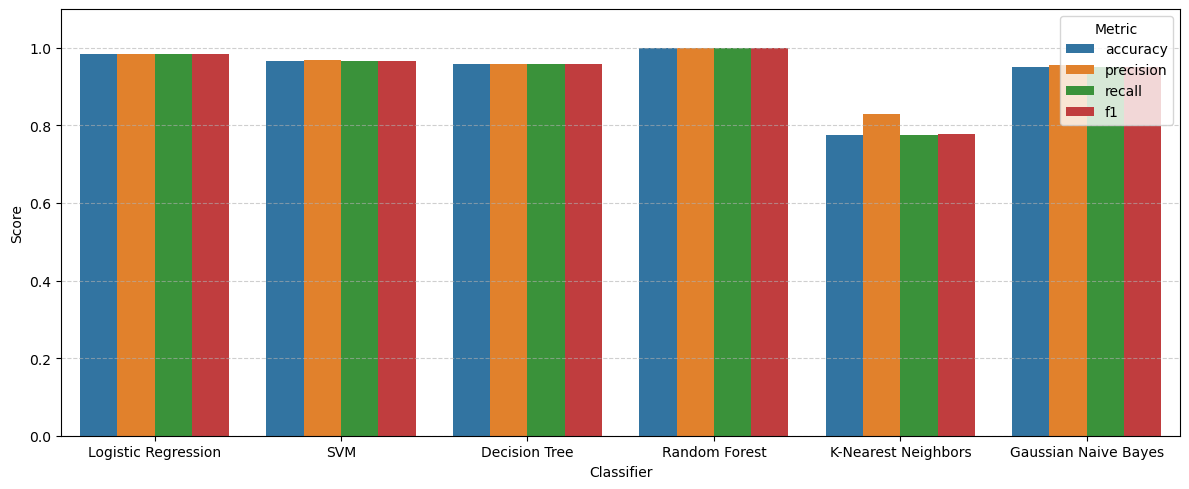

In [13]:
#Evaluation Metrics Comparison BarChart

df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Classifier'})
df_melted = df.melt(id_vars='Classifier', var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 5))
sns.barplot(data=df_melted, x='Classifier', y='Score', hue='Metric')
plt.ylim(0, 1.1)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [14]:
#Saving the best Model

import pickle as pck
filename = "random_forest_model.sav"
pck.dump(best_rf, open(filename, 'wb'))